In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


dropout_value = 0.1

def conv_bn_act(in_ch, out_ch, kernel=3, stride=1, padding=1, dilation=1, dropout_p=0.05):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride,
                  padding=padding, dilation=dilation, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p)
    )

def dws_bn_act(in_ch, out_ch, kernel_size=3, stride=1, padding=1, dilation=1,dropout_p=0.05):
    return nn.Sequential(
        nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, stride=stride,
                            padding=padding, dilation=dilation, groups=in_ch, bias=False),
        nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p)
    )

class Model1(nn.Module):
    def __init__(self, num_classes):
        super(Model1, self).__init__()

        # CONVOLUTION BLOCK 1
        self.c1_1 = conv_bn_act(3, 32, kernel=3, stride=1, padding=1, dilation=1)
        self.c1_2 = conv_bn_act(32, 64, kernel=3, stride=2, padding=1, dilation=1)
        self.onexonec1_1 = conv_bn_act(64, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 2
        self.c2_1 = conv_bn_act(32, 64, kernel=3, stride=1, padding=1, dilation=1)
        self.c2_2 = dws_bn_act(64, 32, kernel_size=3, stride=2, padding=1, dilation=1)
        #self.onexonec2_1 = conv_bn_act(64, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 3
        self.c3_1 = conv_bn_act(32, 32, kernel=3, stride=1, padding=1, dilation=1)
        self.c3_2 = conv_bn_act(32, 64, kernel=3, stride=1, padding=1, dilation=1)
        self.onexonec3_1 = conv_bn_act(64, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 4
        self.c4 = conv_bn_act(32, 64, kernel=3, stride=1, padding=1, dilation=1)
        self.c5 = conv_bn_act(64, 64, kernel=3, stride=1, padding=1, dilation=2)

        # OUTPUT BLOCK
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)


    def forward(self, x):
        # Block 1
        x = self.c1_1(x)
        x = self.c1_2(x)
        x = self.onexonec1_1(x)

        # Block 2
        x = self.c2_1(x)
        x = self.c2_2(x)
        #x = self.onexonec2_1(x)

        # Block 3
        x = self.c3_1(x)
        x = self.c3_2(x)
        x = self.onexonec3_1(x)

        # Block 4 (dilated)
        x = self.c4(x)
        x = self.c5(x)

        # Output Block
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # x = x.view(-1, 10)
        return x

In [32]:
import matplotlib.pyplot as plt


def plot_metrics(train_losses, test_losses, train_acc, test_acc):
    epochs = range(1, len(train_acc) + 1)

    # ----------------------
    # Plot Train Loss
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Test Loss
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Train Accuracy
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, 'g-', label='Train Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.title('Train Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Test Accuracy
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, test_acc, 'm-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

CUDA Available? True
Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,432
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           2,048
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432

Epoch=1 Loss=1.8185 Accuracy=23.47: 100%|██████████| 391/391 [00:18<00:00, 21.56it/s]



Test set: Average loss: 0.0145, Accuracy: 3360/10000 (33.60%)

found perfect model!!
Saved best model (acc=33.60%) to best_model.pth

EPOCH: 2


Epoch=2 Loss=1.7539 Accuracy=34.65: 100%|██████████| 391/391 [00:17<00:00, 21.78it/s]



Test set: Average loss: 0.0128, Accuracy: 3950/10000 (39.50%)

found perfect model!!
Saved best model (acc=39.50%) to best_model.pth

EPOCH: 3


Epoch=3 Loss=1.7126 Accuracy=40.01: 100%|██████████| 391/391 [00:18<00:00, 21.47it/s]



Test set: Average loss: 0.0113, Accuracy: 4728/10000 (47.28%)

found perfect model!!
Saved best model (acc=47.28%) to best_model.pth

EPOCH: 4


Epoch=4 Loss=1.4478 Accuracy=45.15: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]



Test set: Average loss: 0.0106, Accuracy: 5169/10000 (51.69%)

found perfect model!!
Saved best model (acc=51.69%) to best_model.pth

EPOCH: 5


Epoch=5 Loss=1.4349 Accuracy=49.64: 100%|██████████| 391/391 [00:19<00:00, 19.63it/s]



Test set: Average loss: 0.0093, Accuracy: 5757/10000 (57.57%)

found perfect model!!
Saved best model (acc=57.57%) to best_model.pth

EPOCH: 6


Epoch=6 Loss=1.2097 Accuracy=53.31: 100%|██████████| 391/391 [00:20<00:00, 19.23it/s]



Test set: Average loss: 0.0085, Accuracy: 6093/10000 (60.93%)

found perfect model!!
Saved best model (acc=60.93%) to best_model.pth

EPOCH: 7


Epoch=7 Loss=1.3108 Accuracy=55.57: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]



Test set: Average loss: 0.0081, Accuracy: 6287/10000 (62.87%)

found perfect model!!
Saved best model (acc=62.87%) to best_model.pth

EPOCH: 8


Epoch=8 Loss=1.1589 Accuracy=58.20: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s]



Test set: Average loss: 0.0080, Accuracy: 6343/10000 (63.43%)

found perfect model!!
Saved best model (acc=63.43%) to best_model.pth

EPOCH: 9


Epoch=9 Loss=1.1399 Accuracy=60.61: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]



Test set: Average loss: 0.0075, Accuracy: 6767/10000 (67.67%)

found perfect model!!
Saved best model (acc=67.67%) to best_model.pth

EPOCH: 10


Epoch=10 Loss=1.1470 Accuracy=62.67: 100%|██████████| 391/391 [00:19<00:00, 20.49it/s]



Test set: Average loss: 0.0067, Accuracy: 7049/10000 (70.49%)

found perfect model!!
Saved best model (acc=70.49%) to best_model.pth

EPOCH: 11


Epoch=11 Loss=0.9997 Accuracy=64.44: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]



Test set: Average loss: 0.0073, Accuracy: 6777/10000 (67.77%)


EPOCH: 12


Epoch=12 Loss=1.0859 Accuracy=66.10: 100%|██████████| 391/391 [00:18<00:00, 21.12it/s]



Test set: Average loss: 0.0061, Accuracy: 7289/10000 (72.89%)

found perfect model!!
Saved best model (acc=72.89%) to best_model.pth

EPOCH: 13


Epoch=13 Loss=0.8804 Accuracy=67.06: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]



Test set: Average loss: 0.0060, Accuracy: 7326/10000 (73.26%)

found perfect model!!
Saved best model (acc=73.26%) to best_model.pth

EPOCH: 14


Epoch=14 Loss=0.7975 Accuracy=68.13: 100%|██████████| 391/391 [00:17<00:00, 21.82it/s]



Test set: Average loss: 0.0058, Accuracy: 7435/10000 (74.35%)

found perfect model!!
Saved best model (acc=74.35%) to best_model.pth

EPOCH: 15


Epoch=15 Loss=0.8739 Accuracy=68.88: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]



Test set: Average loss: 0.0058, Accuracy: 7458/10000 (74.58%)

found perfect model!!
Saved best model (acc=74.58%) to best_model.pth

EPOCH: 16


Epoch=16 Loss=0.8388 Accuracy=69.65: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]



Test set: Average loss: 0.0056, Accuracy: 7604/10000 (76.04%)

found perfect model!!
Saved best model (acc=76.04%) to best_model.pth

EPOCH: 17


Epoch=17 Loss=0.5579 Accuracy=70.69: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]



Test set: Average loss: 0.0054, Accuracy: 7655/10000 (76.55%)

found perfect model!!
Saved best model (acc=76.55%) to best_model.pth

EPOCH: 18


Epoch=18 Loss=0.8518 Accuracy=71.37: 100%|██████████| 391/391 [00:17<00:00, 22.17it/s]



Test set: Average loss: 0.0050, Accuracy: 7764/10000 (77.64%)

found perfect model!!
Saved best model (acc=77.64%) to best_model.pth

EPOCH: 19


Epoch=19 Loss=0.9665 Accuracy=71.99: 100%|██████████| 391/391 [00:18<00:00, 21.48it/s]



Test set: Average loss: 0.0054, Accuracy: 7636/10000 (76.36%)


EPOCH: 20


Epoch=20 Loss=0.7090 Accuracy=72.54: 100%|██████████| 391/391 [00:17<00:00, 22.10it/s]



Test set: Average loss: 0.0046, Accuracy: 7971/10000 (79.71%)

found perfect model!!
Saved best model (acc=79.71%) to best_model.pth

EPOCH: 21


Epoch=21 Loss=0.7289 Accuracy=73.23: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s]



Test set: Average loss: 0.0049, Accuracy: 7878/10000 (78.78%)


EPOCH: 22


Epoch=22 Loss=0.6262 Accuracy=73.26: 100%|██████████| 391/391 [00:17<00:00, 22.28it/s]



Test set: Average loss: 0.0045, Accuracy: 8036/10000 (80.36%)

found perfect model!!
Saved best model (acc=80.36%) to best_model.pth

EPOCH: 23


Epoch=23 Loss=0.8551 Accuracy=73.72: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s]



Test set: Average loss: 0.0046, Accuracy: 7966/10000 (79.66%)


EPOCH: 24


Epoch=24 Loss=0.9880 Accuracy=74.48: 100%|██████████| 391/391 [00:17<00:00, 22.19it/s]



Test set: Average loss: 0.0050, Accuracy: 7868/10000 (78.68%)


EPOCH: 25


Epoch=25 Loss=0.7037 Accuracy=74.69: 100%|██████████| 391/391 [00:18<00:00, 20.79it/s]



Test set: Average loss: 0.0046, Accuracy: 7949/10000 (79.49%)


EPOCH: 26


Epoch=26 Loss=0.7717 Accuracy=75.06: 100%|██████████| 391/391 [00:18<00:00, 21.71it/s]



Test set: Average loss: 0.0045, Accuracy: 8040/10000 (80.40%)

found perfect model!!
Saved best model (acc=80.40%) to best_model.pth

EPOCH: 27


Epoch=27 Loss=0.8062 Accuracy=75.44: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]



Test set: Average loss: 0.0042, Accuracy: 8200/10000 (82.00%)

found perfect model!!
Saved best model (acc=82.00%) to best_model.pth

EPOCH: 28


Epoch=28 Loss=0.6859 Accuracy=75.49: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]



Test set: Average loss: 0.0041, Accuracy: 8215/10000 (82.15%)

found perfect model!!
Saved best model (acc=82.15%) to best_model.pth

EPOCH: 29


Epoch=29 Loss=0.6524 Accuracy=76.00: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]



Test set: Average loss: 0.0041, Accuracy: 8203/10000 (82.03%)


EPOCH: 30


Epoch=30 Loss=0.6700 Accuracy=76.32: 100%|██████████| 391/391 [00:18<00:00, 21.72it/s]



Test set: Average loss: 0.0042, Accuracy: 8197/10000 (81.97%)


EPOCH: 31


Epoch=31 Loss=0.5504 Accuracy=76.46: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s]



Test set: Average loss: 0.0039, Accuracy: 8314/10000 (83.14%)

found perfect model!!
Saved best model (acc=83.14%) to best_model.pth

EPOCH: 32


Epoch=32 Loss=0.7393 Accuracy=76.63: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]



Test set: Average loss: 0.0039, Accuracy: 8333/10000 (83.33%)

found perfect model!!
Saved best model (acc=83.33%) to best_model.pth

EPOCH: 33


Epoch=33 Loss=0.7766 Accuracy=76.82: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]



Test set: Average loss: 0.0038, Accuracy: 8339/10000 (83.39%)

found perfect model!!
Saved best model (acc=83.39%) to best_model.pth

EPOCH: 34


Epoch=34 Loss=0.5307 Accuracy=77.06: 100%|██████████| 391/391 [00:18<00:00, 20.80it/s]



Test set: Average loss: 0.0038, Accuracy: 8351/10000 (83.51%)

found perfect model!!
Saved best model (acc=83.51%) to best_model.pth

EPOCH: 35


Epoch=35 Loss=0.6574 Accuracy=77.28: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s]



Test set: Average loss: 0.0038, Accuracy: 8411/10000 (84.11%)

found perfect model!!
Saved best model (acc=84.11%) to best_model.pth

EPOCH: 36


Epoch=36 Loss=0.5667 Accuracy=77.77: 100%|██████████| 391/391 [00:18<00:00, 21.44it/s]



Test set: Average loss: 0.0037, Accuracy: 8382/10000 (83.82%)


EPOCH: 37


Epoch=37 Loss=0.7300 Accuracy=77.75: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]



Test set: Average loss: 0.0037, Accuracy: 8349/10000 (83.49%)


EPOCH: 38


Epoch=38 Loss=0.6499 Accuracy=78.19: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]



Test set: Average loss: 0.0036, Accuracy: 8438/10000 (84.38%)

found perfect model!!
Saved best model (acc=84.38%) to best_model.pth

EPOCH: 39


Epoch=39 Loss=0.5336 Accuracy=78.12: 100%|██████████| 391/391 [00:19<00:00, 20.55it/s]



Test set: Average loss: 0.0036, Accuracy: 8389/10000 (83.89%)


EPOCH: 40


Epoch=40 Loss=0.9643 Accuracy=78.87: 100%|██████████| 391/391 [00:18<00:00, 21.68it/s]



Test set: Average loss: 0.0035, Accuracy: 8437/10000 (84.37%)


EPOCH: 41


Epoch=41 Loss=0.7252 Accuracy=78.62: 100%|██████████| 391/391 [00:18<00:00, 21.13it/s]



Test set: Average loss: 0.0035, Accuracy: 8461/10000 (84.61%)

found perfect model!!
Saved best model (acc=84.61%) to best_model.pth

EPOCH: 42


Epoch=42 Loss=0.6415 Accuracy=78.78: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s]



Test set: Average loss: 0.0035, Accuracy: 8510/10000 (85.10%)

found perfect model!!
Saved best model (acc=85.10%) to best_model.pth
-----------------------------------------
train accuracies 42 [23.466, 34.648, 40.01, 45.146, 49.642, 53.306, 55.574, 58.204, 60.612, 62.67, 64.438, 66.1, 67.058, 68.132, 68.878, 69.646, 70.69, 71.37, 71.988, 72.536, 73.23, 73.256, 73.716, 74.476, 74.694, 75.056, 75.436, 75.49, 76.004, 76.32, 76.464, 76.626, 76.824, 77.058, 77.282, 77.772, 77.754, 78.186, 78.118, 78.866, 78.616, 78.776]
train losses 42 [811.7341247797012, 708.0607417821884, 643.3384265899658, 588.1413350105286, 544.1315767765045, 508.1822839975357, 478.8545066714287, 453.2514132261276, 430.3270736336708, 408.7904758453369, 391.4765716791153, 374.9022520184517, 363.42808598279953, 352.7088711261749, 343.12670636177063, 334.29153698682785, 323.9599035382271, 317.978025496006, 311.11944395303726, 306.0806405544281, 299.45538330078125, 295.75309067964554, 291.48023506999016, 284.859047532081

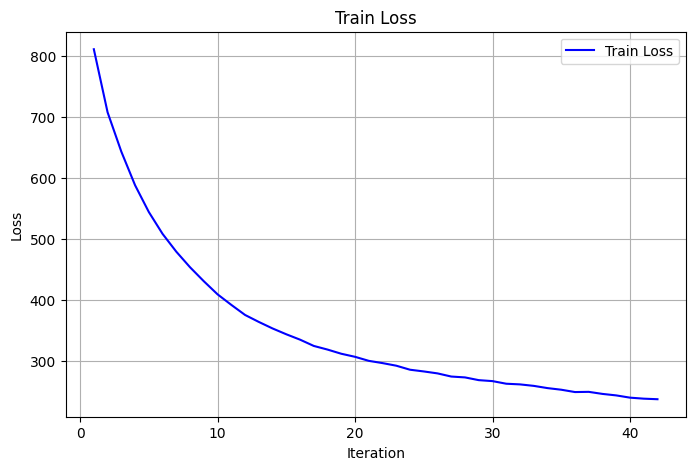

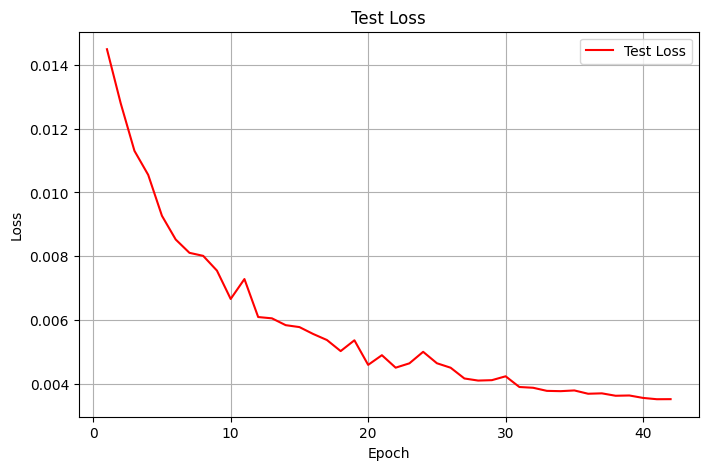

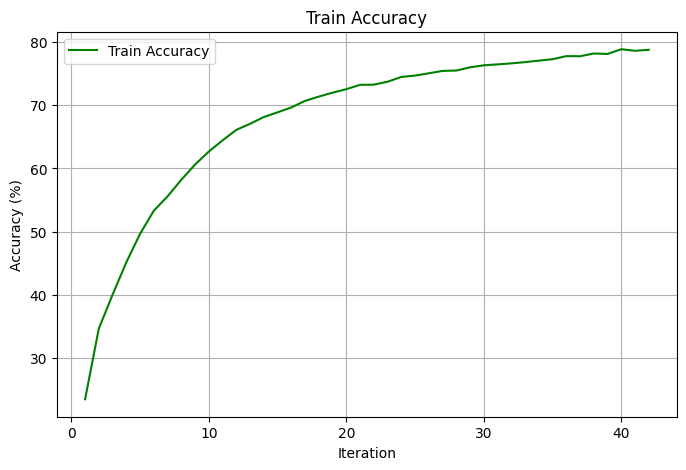

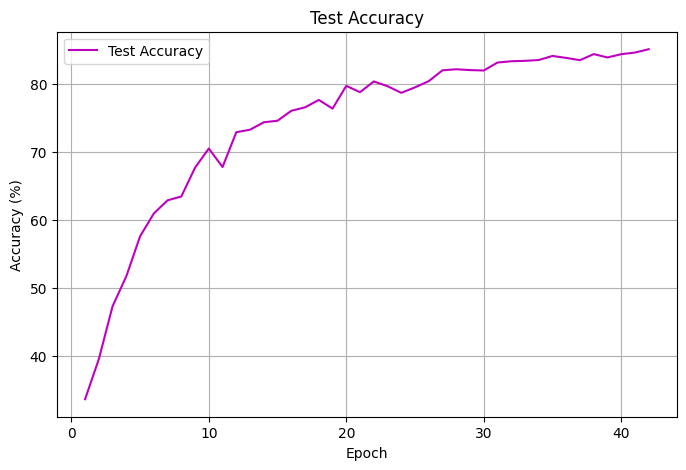

In [33]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import OneCycleLR
# from models import Model1
# from utils import plot_metrics


def train(model, device, train_loader, optimizer, scheduler, criterion, epoch, train_losses, train_acc):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)   # expects log_softmax in model forward
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        # if batch_idx > 5:
        #     break
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        acc = 100. * correct / processed
        pbar.set_description(desc=f'Epoch={epoch} Loss={loss.item():.4f} Accuracy={acc:0.2f}')
        #train_acc.append(acc)
    train_losses.append(train_loss)
    acc = 100. * correct / len(train_loader.dataset)
    train_acc.append(acc)


def test(model, device, test_loader, criterion, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(acc)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')
    return acc

def get_data_loaders():
    # CIFAR-10 mean and std
    CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
    CIFAR10_STD  = (0.2470, 0.2435, 0.2616)


    fill_value_pixels = tuple(int(m * 255) for m in CIFAR10_MEAN)

    train_alb = A.Compose([
        A.HorizontalFlip(p=0.5),
         A.Affine(
            translate_percent={"x": 0.0625, "y": 0.0625},  # shift
            scale=(0.9, 1.1),                               # scale
            rotate=(-15, 15),                               # rotation
            p=0.5
        ),
        A.CoarseDropout(
            num_holes_range=(1, 1),
            hole_height_range=(16, 16),
            hole_width_range=(16, 16),
            fill=fill_value_pixels,
            fill_mask=None,
            p=0.5
        ),
        A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
        ToTensorV2(),
    ])

    val_alb = A.Compose([
        A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
        ToTensorV2(),
    ])

    class AlbCIFAR10(datasets.CIFAR10):
        def __init__(self, root, train=True, transform=None, download=False):
            super().__init__(root=root, train=train, download=download)
            self.alb_transform = transform

        def __getitem__(self, index):
            img, target = self.data[index], int(self.targets[index])
            # img is HxWxC numpy (uint8)
            if self.alb_transform:
                augmented = self.alb_transform(image=img)
                img = augmented["image"]
            else:
                # fallback: convert to tensor and normalize
                img = transforms.ToTensor()(img)
            return img, target



    # train_transforms = transforms.Compose([
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean, std)
    # ])

    # test_transforms = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean, std)
    # ])

    # train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
    # test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

    train = AlbCIFAR10(root='./data', train=True, transform=train_alb, download=True)
    test   = AlbCIFAR10(root='./data', train=False, transform=val_alb, download=True)

    SEED = 1
    cuda = torch.cuda.is_available()
    print("CUDA Available?", cuda)
    torch.manual_seed(SEED)
    if cuda:
        torch.cuda.manual_seed(SEED)

    dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda \
                      else dict(shuffle=True, batch_size=64)
    train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
    test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
    return train_loader, test_loader, cuda

def perform_training():
    train_loader, test_loader, use_cuda = get_data_loaders()
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Using device:", device)

    number_of_classes = 10
    model = Model1(number_of_classes).to(device)
    summary(model, input_size=(3, 32, 32))  # CIFAR-10 input size

    # return
    #optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    EPOCHS = 80
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),

        epochs=EPOCHS,
        pct_start=0.2,
        anneal_strategy="cos",
    )

    EPOCHS = 100
    SAVE_PATH = "best_model.pth"

    train_losses, test_losses, train_acc, test_acc = [], [], [], []
    best_val_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        print(f"\nEPOCH: {epoch}")
        train(model, device, train_loader, optimizer, scheduler, criterion, epoch, train_losses, train_acc)
        current_test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)
        if current_test_acc >= best_val_acc:
            print("found perfect model!!")
            best_val_acc = current_test_acc
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_acc": current_test_acc,
            }, SAVE_PATH)
            print(f"Saved best model (acc={best_val_acc:.2f}%) to {SAVE_PATH}")
            if best_val_acc >= 85.0:
                break

    print("-----------------------------------------")
    print("train accuracies", len(train_acc), train_acc)
    print("train losses", len(train_losses), train_losses)
    print("-----------------------------------------")
    print("-----------------------------------------")
    print("test accuracies", len(test_acc), test_acc)
    print("test losses", len(test_losses), test_losses)
    print("-----------------------------------------")
    plot_metrics(train_losses, test_losses, train_acc, test_acc)

if __name__ == '__main__':
    perform_training()